In [1]:
input_file = 'mh_aggr.out'

import pathlib
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
import tensorflow_probability as tfp

import sys
sys.path.append('/Users/jay/Desktop/Bachelorarbeit/Implementation')
from dependencies.hbv_sask.model import HBVSASKModel as hbvmodel
from src.execute_model import run_model_single_parameter_node
from src.construct_model import get_model


ndims = 7
dims = ['TT', 'C0', 'beta', 'ETF', 'FC', 'FRAC', 'K2']
colors = sns.color_palette(n_colors=ndims)

configPath = "/Users/jay/Desktop/Bachelorarbeit/Implementation/configurations/config_1.json"
basis = "Oldman_Basin"
model = get_model(configPath, basis)

start_date: 2006-03-30 00:00:00
start_date_predictions: 2007-03-30 00:00:00
end_date: 2007-04-30 00:00:00
simulation length: 31
full_data_range is 397 hours including spin_up_length of 365 hours
simulation_range is of length 32 hours


In [2]:
# Construct params
configurationObject = model.configurationObject
param_lower = []
param_upper = []
for param in configurationObject["parameters"]:
    # for now the Uniform distribution is only supported
    if param["distribution"] == "Uniform":
        param_lower.append(param["lower"])
        param_upper.append(param["upper"])
    else:
        raise NotImplementedError(f"Sorry, the distribution {param['distribution']} is not supported yet")
param_lower = np.array(param_lower)
param_upper = np.array(param_upper)


def displot(i, data):
    # Plot sampled distribution
    fig = sns.displot(data, x=dims[i], kde=True, color=colors[i])

    # Plot distribution that is sampled from
    #uni = uniform(loc=param_lower[i], scale=param_upper[i] - param_lower[i])
    uni = tfp.distributions.Uniform(low=param_lower[i], high=param_upper[i])
    x = np.linspace(param_lower[i], param_upper[i], 25000)
    y = uni.prob(x)

    # Configuration
    plt.plot(x, y, label='pdf', color='grey')
    plt.title(f'PDF of parameter {dims[i]}')
    plt.show()
    fig.savefig(f'{dims[i]}_kde.png') 

def boxplot(i, data):
    sns.boxplot(data, x=dims[i], color=colors[i])
    plt.title(f'Boxplot of parameter {dims[i]}')
    plt.savefig(f'{dims[i]}_box.png')



In [3]:
samples = pd.read_csv(f'{input_file}')
samples

,TT,C0,beta,ETF,FC,FRAC,K2
0,0.792278,1.566456,2.015827,0.783540,366.247575,0.1,0.050000
1,0.792278,1.566456,2.015827,0.783540,366.247575,0.1,0.050000
2,0.792278,1.566456,2.015827,0.783540,366.247575,0.1,0.050000
3,0.792278,1.566456,2.015827,0.783540,366.247575,0.1,0.050000
4,0.792278,1.566456,2.015827,0.783540,366.247575,0.1,0.050000
...,...,...,...,...,...,...,...
7996,2.013543,1.652548,1.746948,0.335282,197.496563,0.1,0.027743
7997,2.013543,1.652548,1.746948,0.335282,197.496563,0.1,0.027743
7998,2.013543,1.652548,1.746948,0.335282,197.496563,0.1,0.027743
7999,2.013543,1.652548,1.746948,0.335282,197.496563,0.1,0.027743


# Plotting

/Users/jay/miniconda3/envs/hbv_uq_env/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning:

The figure layout has changed to tight

2024-05-20 01:40:23.331530: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1 Pro
2024-05-20 01:40:23.331552: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 32.00 GB
2024-05-20 01:40:23.331557: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 10.67 GB
2024-05-20 01:40:23.331575: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-05-20 01:40:23.331588: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


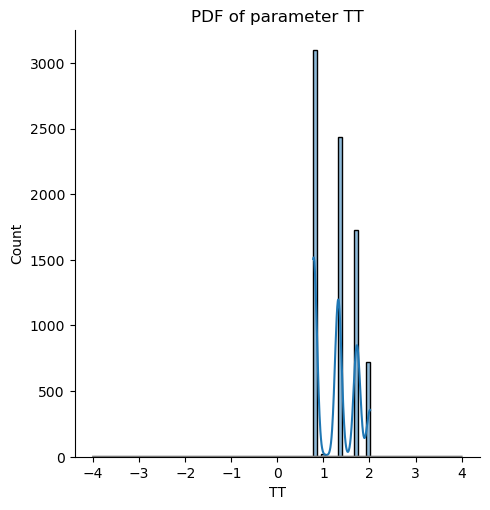

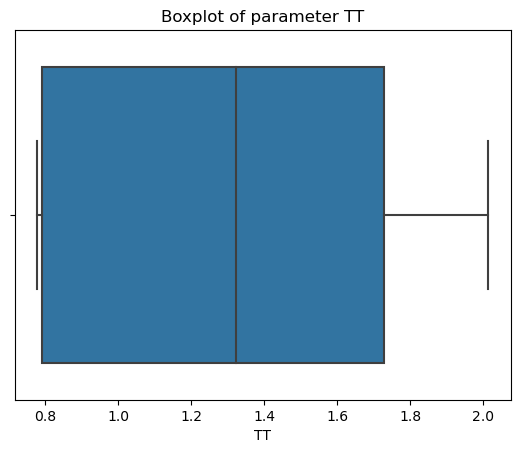

In [4]:
# Plot TT
displot(0, samples)
boxplot(0, samples)

/Users/jay/miniconda3/envs/hbv_uq_env/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning:

The figure layout has changed to tight



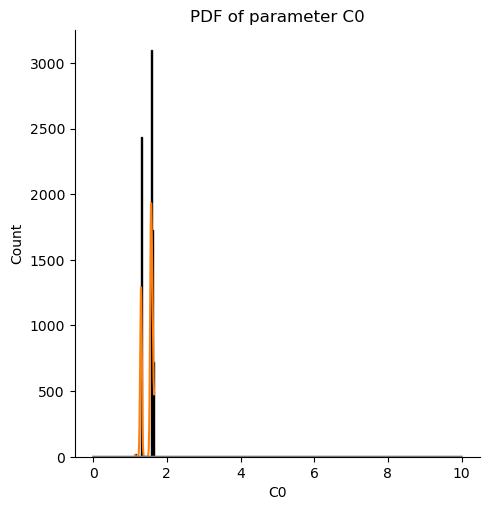

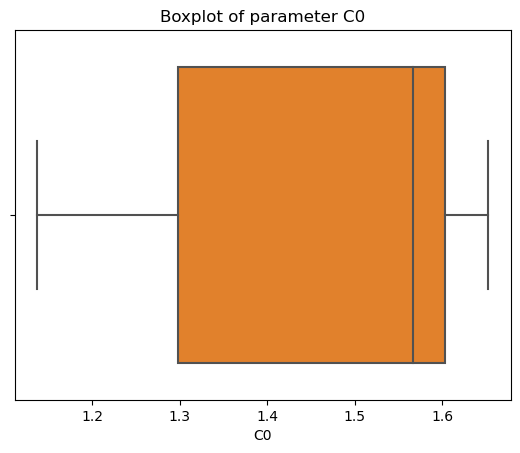

In [5]:
# Plot TT
displot(1, samples)
boxplot(1, samples)

/Users/jay/miniconda3/envs/hbv_uq_env/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning:

The figure layout has changed to tight



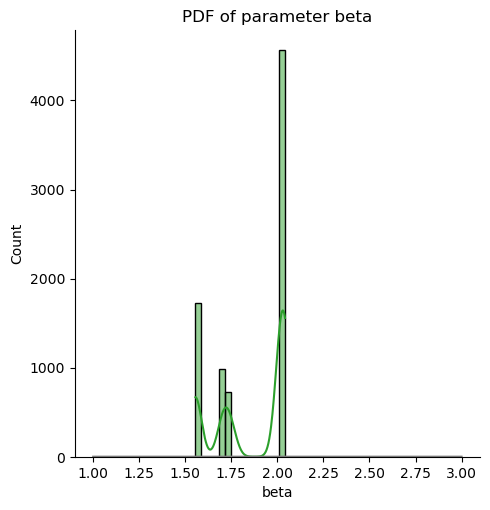

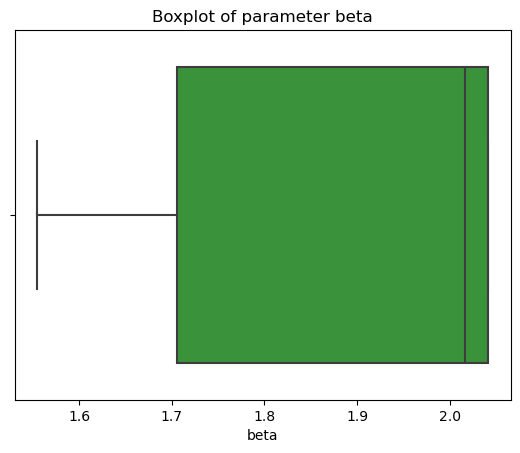

In [6]:
# Plot TT
displot(2, samples)
boxplot(2, samples)

/Users/jay/miniconda3/envs/hbv_uq_env/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning:

The figure layout has changed to tight



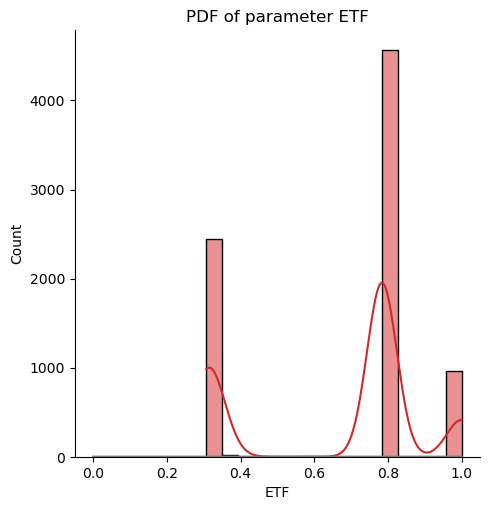

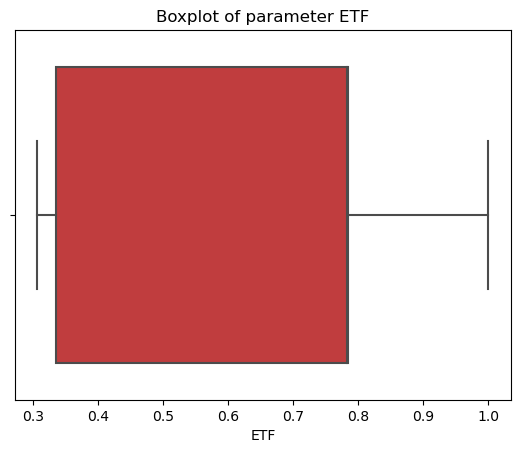

In [7]:
displot(3, samples)
boxplot(3, samples)

/Users/jay/miniconda3/envs/hbv_uq_env/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning:

The figure layout has changed to tight



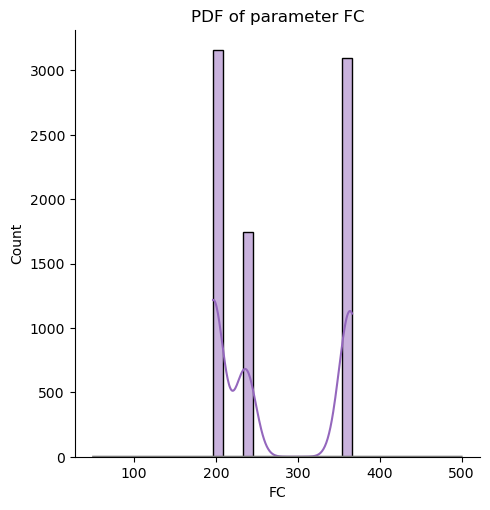

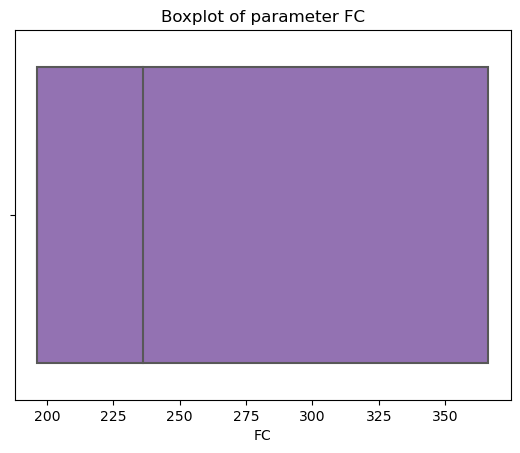

In [8]:
displot(4, samples)
boxplot(4, samples)

/Users/jay/miniconda3/envs/hbv_uq_env/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning:

The figure layout has changed to tight



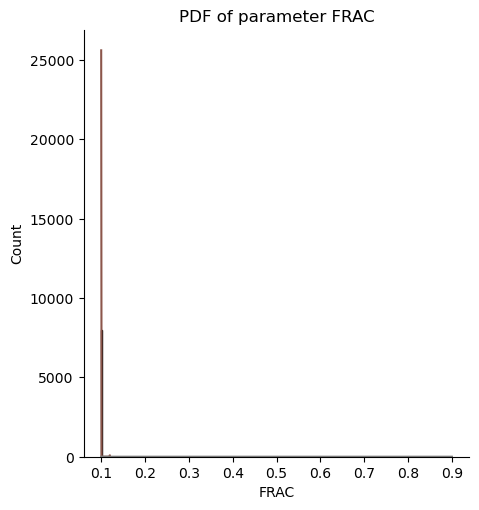

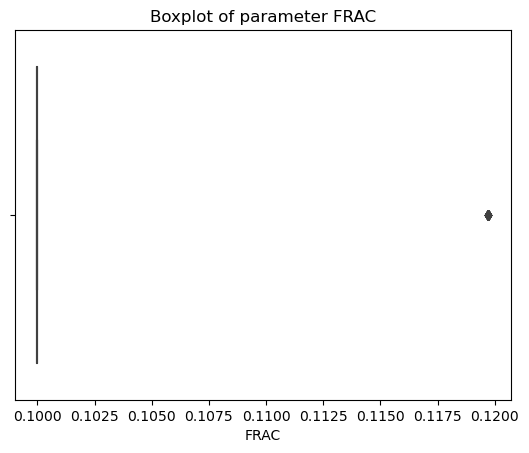

In [9]:
displot(5, samples)
boxplot(5, samples)

/Users/jay/miniconda3/envs/hbv_uq_env/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning:

The figure layout has changed to tight



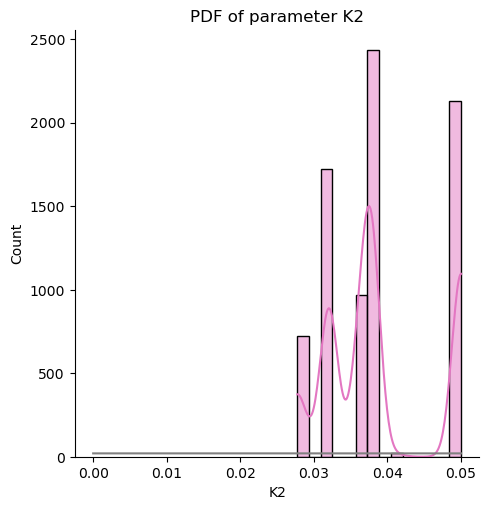

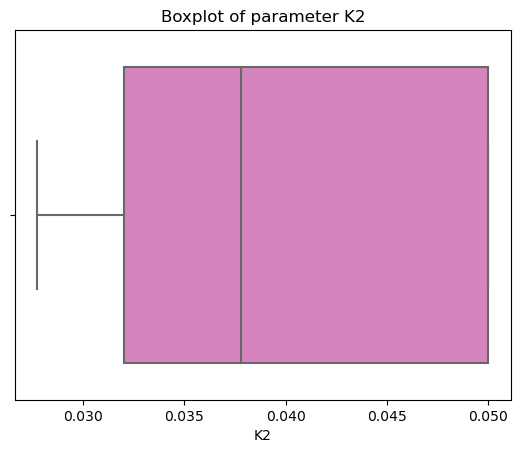

In [10]:
displot(6, samples)
boxplot(6, samples)

# Sampling

In [11]:
# Sampling Max
param_vec = []
for i in range(len(samples.loc[0])):
    values, counts = np.unique(samples.iloc[:, i], return_counts=True)
    ind = np.argmax(counts)
    param_vec.append(values[ind])

_, sampled_max, _, _ = run_model_single_parameter_node(model, param_vec)
    

[HVBSASK INFO] [0] parameters: [[1.322359053422289, 1.2979308430655458, 2.041420736015416, 0.7840419734477735, 196.36110869322852, 0.1, 0.03778471991568659]]


In [12]:
# Mean Sampling from MCMC
sample_param = []
for i in range(7):
    sample_param.append(np.random.choice(samples.iloc[:, i], 1000))
sample_param = np.array(sample_param).T

all_results = []
for _, vec in enumerate(sample_param):
    _, y_model, _, _ = run_model_single_parameter_node(model, np.array(vec))
    all_results.append(y_model)

print(np.array(all_results).shape)
sampled_column_means = np.mean(np.array(all_results), axis=0) 


[HVBSASK INFO] [0] parameters: [array([7.92278188e-01, 1.29793084e+00, 2.01582693e+00, 7.83540159e-01,
       1.97496563e+02, 1.00000000e-01, 5.00000000e-02])]
[HVBSASK INFO] [0] parameters: [array([1.32235905e+00, 1.60359451e+00, 2.04142074e+00, 1.00000000e+00,
       3.57471924e+02, 1.00000000e-01, 5.00000000e-02])]
[HVBSASK INFO] [0] parameters: [array([1.32235905e+00, 1.60359451e+00, 2.04142074e+00, 1.00000000e+00,
       3.57471924e+02, 1.00000000e-01, 3.20362660e-02])]
[HVBSASK INFO] [0] parameters: [array([7.92278188e-01, 1.29793084e+00, 2.04142074e+00, 7.83540159e-01,
       3.66247575e+02, 1.00000000e-01, 3.77847199e-02])]
[HVBSASK INFO] [0] parameters: [array([1.72683770e+00, 1.60359451e+00, 1.55507015e+00, 7.83540159e-01,
       1.97496563e+02, 1.00000000e-01, 3.61906204e-02])]
[HVBSASK INFO] [0] parameters: [array([7.92278188e-01, 1.29793084e+00, 2.04142074e+00, 1.00000000e+00,
       3.57471924e+02, 1.00000000e-01, 5.00000000e-02])]
[HVBSASK INFO] [0] parameters: [array([1

In [13]:
# Mean Sampling from Start
sample_param = []
for i in range(7):
    uni = tfp.distributions.Uniform(low=param_lower[i], high=param_upper[i]).sample(1)
    sample_param.append(uni)
sample_param = np.array(sample_param).T

all_results = []
for _, vec in enumerate(sample_param):
    _, y_model, _, _ = run_model_single_parameter_node(model, np.array(vec))
    all_results.append(y_model)

_, _, measured_data, _ = run_model_single_parameter_node(model, np.array(vec))

start_column_means = np.mean(np.array(all_results), axis=0)
    

[HVBSASK INFO] [0] parameters: [array([-1.63964689e+00,  8.14557540e-01,  1.84016687e+00,  1.73477433e-01,
        2.88522084e+02,  1.61377621e-01,  4.79652837e-02])]
[HVBSASK INFO] [0] parameters: [array([-1.63964689e+00,  8.14557540e-01,  1.84016687e+00,  1.73477433e-01,
        2.88522084e+02,  1.61377621e-01,  4.79652837e-02])]


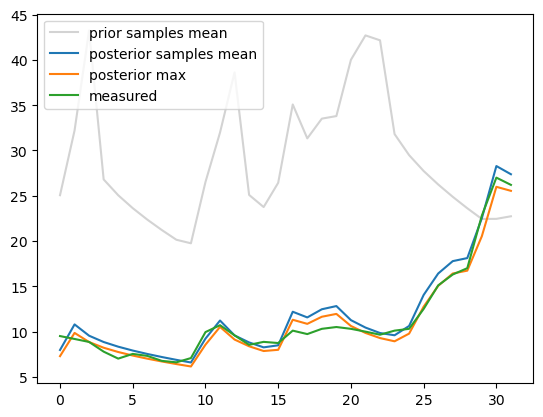

In [14]:
fig = plt.figure()
plt.plot(start_column_means, label='prior samples mean', color='lightgrey')
plt.plot(sampled_column_means, label='posterior samples mean')
plt.plot(sampled_max, label='posterior max')
plt.plot(measured_data, label='measured')
plt.legend()
plt.show()

In [15]:
t = (all_results - measured_data)[0]

s = 0
for i in range(len(t)):
    s += t[i] ** 2
rmse = (s / (len(t))) ** 0.5
rmse

19.83776958690347

In [16]:
t = sampled_max - measured_data

s = 0
for i in range(len(t)):
    s += t[i] ** 2
rmse = (s / (len(t))) ** 0.5
rmse

0.9048990071717647

In [17]:
t = np.absolute(sampled_column_means - measured_data)

t.mean()

0.9180631933232334

In [18]:
t = np.absolute(sampled_max - measured_data)

t.mean()

0.6866302747380377